# Desafio Técnico – Projeto P&D Multicloud com IA

**Autor:** Alan Teixeira  
**LinkedIn:** [https://www.linkedin.com/in/alanst/](https://www.linkedin.com/in/alanst/)  
**GitHub:** [https://github.com/AlanSTeixeira](https://github.com/AlanSTeixeira)  

Este projeto faz parte do desafio da **Trilha A – Dados & IA**, cujo objetivo é criar um **pipeline simples de ingestão e processamento de dados multicloud**, utilizando fontes públicas de preços de provedores como Azure, Oracle, AWS e GCP.

Neste protótipo, foi desenvolvido um pipeline para **coletar dados públicos de preços de máquinas virtuais (VMs)** do **Microsoft Azure e da Oracle**.  
O pipeline realiza:
- Processamento e limpeza das informações
- Análise exploratória de dados (EDA) para Azure e Oracle
- Aplicação de **Machine Learning** nos dados da Azure, incluindo: 
     - **Clustering (K-Means)** para identificar padrões de preços por região
     - **Modelo de Regressão (Random Forest)** para prever valores de preço com base nas características das VMs

O objetivo é demonstrar um fluxo inicial que pode ser expandido para integrar múltiplos provedores, permitindo **comparações de custo, análises de eficiência financeira** e aplicação de **modelos preditivos** para otimização de recursos em ambientes multicloud.


## Estrutura do Projeto
- **dados/** → Armazena todos os datasets utilizados ou gerados pelo notebook  
- **figuras/** → Contém as figuras e gráficos gerados durante a execução  
- **Desafio ICT ITAÚ.ipynb** → Notebook principal com todo o pipeline  
- **requirements.txt** → Lista das dependências necessárias para executar o projeto  

---

## Como Executar
1. **Clonar o repositório** ou baixar os arquivos.
2. **Instalar as dependências**:
   ```bash
   pip install -r requirements.txt


## Estrutura do Notebook

### Pipeline simples de ingestão e processamento de dados

1. **Coleta de Dados**  
   Explicação da extração dos dados públicos da API da Azure e salvamento dos dados brutos.

2. **Processamento dos Dados**  
   Limpeza, tratamento e preparação dos dados para análise.

3. **Análise Exploratória de Dados (EDA)**  
   Estatísticas descritivas e visualizações para entendimento do dataframe.

4. **Insights baseados na EDA**  
   Geração de conclusões e interpretações a partir das visualizações e estatísticas da EDA.

5. **Tratando outliers**  
   Aplicação de métodos para mitigar o impacto de valores extremos (outliers) nos dados, preparando-os para a modelagem.

---

### Desafio adicional: Implementar um modelo de machine learning

6. **Clustering (K-Means)**  
   Agrupamento das máquinas virtuais com base nos preços para identificação de padrões.

7. **Modelo de Regressão (Random Forest)**  
   Construção e avaliação de um modelo preditivo para estimar os preços das VMs.

8. **Análise do Modelo de Regressão**  
   Interpretação das métricas de erro (MAE e RMSE) para avaliar a precisão e a eficácia do modelo preditivo.

9. **Análise do Clustering (K-Means)**  
   Interpretação dos grupos formados pelo K-Means para identificar padrões de comportamento e faixas de preço entre as regiões.

10. **Comparação de Estruturas de Dados e Desafios de Análise**      
    Resumo da comparação entre a estrutura das Nuvens Azure e Oracle

11. **Conclusão**  
    Resumo dos resultados obtidos e próximos passos sugeridos.


# Pipeline simples de ingestão e processamento de dados

### Ingestão e Processamento de Dados

Os dados utilizados neste projeto foram extraídos de **APIs públicas de provedores de nuvem**, especificamente do **Microsoft Azure e da Oracle Cloud**. Ambas as APIs fornecem informações atualizadas sobre preços e especificações de máquinas virtuais (VMs) e outros serviços.

A ingestão de dados segue um processo padronizado para ambos os provedores:
1.  Acessar os endpoints das respectivas APIs.
2.  Coletar os registros no formato **JSON**.
3.  Converter a estrutura aninhada para um formato tabular utilizando a biblioteca **Pandas**.

Após a extração, os dados brutos de cada provedor são armazenados localmente no diretório `dados/`, com os nomes `azure_vm_prices_brutos.csv` e `oracle_vm_prices_brutos.csv`, preservando o conteúdo original.

Em seguida, os dados passam pela etapa de processamento. Para o Azure, isso envolve a limpeza, normalização de colunas e a conversão de tipos de dados. Já para a Oracle, o processo é adaptado para lidar com as particularidades da sua estrutura de dados, como a coluna `currencyCodeLocalizations`, que exigiu uma análise específica e a decisão de não extrair os valores monetários por eles estarem ausentes.

O resultado final do processamento é salvo como `azure_vm_prices_tratados.csv` e `oracle_vm_prices_tratados.csv` no diretório `dados/`, estando prontos para uso em análises e modelagem preditiva.

## 1. Coleta de Dados

### Baixando  as bibliotecas necessárias

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import numpy as np
import requests

### Criando pastas necessárias

In [3]:
# Criando uma pasta chamada dados
os.makedirs("dados", exist_ok=True)
# Criando uma pasta chamada figuras
os.makedirs("figuras", exist_ok=True)

### Funções de Ingestão

### Dados Azure Cloud

Nesta etapa, o pipeline acessa a ***Azure Retail Prices API***, que fornece os preços públicos utilizados pelo **Azure Pricing Calculator**. É feita uma requisição HTTP para obter os dados das VMs, que são convertidos de JSON para DataFrame Pandas e salvos como `azure_vm_prices_brutos.csv`.

In [4]:
def coletar_dados_azure():
    url = "https://prices.azure.com/api/retail/prices?$filter=serviceName eq 'Virtual Machines'&$top=1000"
    response = requests.get(url)

    try:
        data = response.json()
        df = pd.DataFrame(data['Items'])
        df.to_csv("dados/azure_vm_prices_brutos.csv", index=False)
        print("[OK] Dados brutos do Azure salvos em 'dados/azure_vm_prices_brutos.csv'")
        return df
    except ValueError:
        print("[ERRO] Não foi possível interpretar como JSON")
        print(response.text)
        return pd.DataFrame()

### Vizualizando o dataframe Azure

In [5]:
# lendo o CSV bruto
df_bruto = coletar_dados_azure()

# visualizar as primeiras linhas com todas as colunas
df_bruto.head()

[OK] Dados brutos do Azure salvos em 'dados/azure_vm_prices_brutos.csv'


,currencyCode,tierMinimumUnits,retailPrice,unitPrice,armRegionName,location,effectiveStartDate,meterId,meterName,productId,...,productName,skuName,serviceName,serviceId,serviceFamily,unitOfMeasure,type,isPrimaryMeterRegion,armSkuName,reservationTerm
0,USD,0.0,0.019008,0.019008,indonesiacentral,ID Central,2025-08-01T00:00:00Z,00009753-d85a-5581-883d-a9b7620cf39b,D2a v4/D2as v4 Spot,DZH318Z0CM2B,...,Virtual Machines Dav4 Series,D2a v4 Spot,Virtual Machines,DZH313Z7MMC8,Compute,1 Hour,Consumption,True,Standard_D2a_v4,NaN
1,USD,0.0,0.478000,0.478000,uaenorth,AE North,2025-06-01T00:00:00Z,9e701f82-855d-529a-9a2f-f1eb873b9b88,E4-2as v6,DZH318Z0F5F3,...,Virtual Machines Easv6 Series Windows,E4-2as v6,Virtual Machines,DZH313Z7MMC8,Compute,1 Hour,Consumption,False,Standard_E4-2as_v6,NaN
2,USD,0.0,0.294000,0.294000,uaenorth,AE North,2025-06-01T00:00:00Z,9e701f82-855d-529a-9a2f-f1eb873b9b88,E4-2as v6,DZH318Z0F5F3,...,Virtual Machines Easv6 Series Windows,E4-2as v6,Virtual Machines,DZH313Z7MMC8,Compute,1 Hour,DevTestConsumption,False,Standard_E4-2as_v6,NaN
3,USD,0.0,0.734000,0.734000,switzerlandnorth,CH North,2022-12-01T00:00:00Z,7d3befd6-d304-5c79-aa4e-4b5450973b73,D16as v4 Low Priority,DZH318Z0CM93,...,Virtual Machines Dasv4 Series Windows,D16as v4 Low Priority,Virtual Machines,DZH313Z7MMC8,Compute,1 Hour,Consumption,False,Standard_D16as_v4,NaN
4,USD,0.0,0.220000,0.220000,switzerlandnorth,CH North,2022-12-01T00:00:00Z,7d3befd6-d304-5c79-aa4e-4b5450973b73,D16as v4 Low Priority,DZH318Z0CM93,...,Virtual Machines Dasv4 Series Windows,D16as v4 Low Priority,Virtual Machines,DZH313Z7MMC8,Compute,1 Hour,DevTestConsumption,False,Standard_D16as_v4,NaN


Observando o head do dataframe da Azure podemos definir o seguinte: 

### Colunas Importantes para o Pipeline de Dados Azure

Ao construir o pipeline, estas colunas são essenciais para a análise exploratória de dados (EDA), 
modelagem de machine learning (regressão e clustering) e para a interpretação dos resultados.

- `retailPrice`: O valor de preço unitário público do serviço. Esta é a nossa **variável-alvo** principal para a regressão.
- `unitPrice`: O preço unitário efetivo. Pode ser usado para comparações e validação.
- `armRegionName`: O nome técnico da região do Azure.
- `location`: O nome legível da região. Pode ser usado em conjunto com `armRegionName` para análises por localidade.
- `productName`: O nome do produto ou da máquina virtual (VM). Essencial para identificar e agrupar padrões de custo.
- `skuName`: O SKU (Stock Keeping Unit) do produto, que geralmente indica as configurações técnicas da VM.
- `serviceName`: O tipo de serviço oferecido (por exemplo, "Virtual Machines"). Útil se o conjunto de dados incluir múltiplos serviços.
- `type`: O tipo de consumo (por exemplo, "Consumption" ou "DevTestConsumption"). Esta informação pode ter um impacto direto no preço.

### Colunas Menos Relevantes (podem ser excluídas)

Essas são códigos internos ou redundâncias que não ajudam na análise:

- `currencyCode`: sempre USD (redundante).

- `unitOfMeasure`: A unidade de medida do preço (por exemplo, "hours" ou "months"). tem apenas um valor (1 Hour).

- `tierMinimumUnits`: geralmente 0, pouco relevante para preços unitários.

- `effectiveStartDate`: pode ser descartada se não for fazer análise temporal.

- `meterId, productId, skuId, serviceId`: IDs internos, não têm valor analítico direto.

- `meterName`: pode ser redundante com skuName ou productName.

- `serviceFamily`: redundante com serviceName em muitos casos.

- `isPrimaryMeterRegion`: flag booleana pouco útil para análise geral.

- `armSkuName`: redundante com skuName.

- `reservationTerm`: quase sempre NaN em datasets públicos.` 

### Dados Oracle Cloud

Nesta etapa, o pipeline acessa a **Oracle Cloud Pricing API**, que fornece os preços dos produtos e serviços do Oracle Cloud. Uma requisição HTTP é feita para a API, obtendo os dados de precificação que são então convertidos de JSON para um **DataFrame Pandas**. Em seguida, esses dados são normalizados para uma estrutura tabular e salvos como `oracle_vm_prices_brutos.csv`.

In [6]:
def coletar_dados_oracle():
    url = "https://apexapps.oracle.com/pls/apex/cetools/api/v1/products/"
    response = requests.get(url)

    try:
        data_oracle = response.json()
        df_oracle = pd.DataFrame(data_oracle['items'])
        df_oracle.to_csv("dados/oracle_vm_prices_brutos.csv", index=False)
        print("[OK] Dados brutos do Oracle salvos em 'dados/oracle_vm_prices_brutos.csv'")
        return df_oracle
    except ValueError:
        print("[ERRO] Não foi possível interpretar como JSON")
        print(response.text)
        return pd.DataFrame()

### Vizualizando o dataframe Oracle

In [7]:
# lendo o CSV bruto
df_bruto_oracle = coletar_dados_oracle()

# visualizar as primeiras linhas com todas as colunas
df_bruto_oracle.head()

[OK] Dados brutos do Oracle salvos em 'dados/oracle_vm_prices_brutos.csv'


,partNumber,displayName,metricName,serviceCategory,currencyCodeLocalizations,description
0,B107951,Oracle Exadata Exascale VM Filesystem Storage,Gigabyte (GB) Storage Capacity Per Month,Exadata Exascale Infrastructure,"[{'currencyCode': 'USD', 'prices': [{'model': ...",NaN
1,B107952,Oracle Exadata Exascale Smart Database Storage,Gigabyte (GB) Storage Capacity Per Month,Exadata Exascale Infrastructure,"[{'currencyCode': 'USD', 'prices': [{'model': ...",NaN
2,B107975,OCI - FastConnect 400 Gbps,Port Hour,Networking - FastConnect,"[{'currencyCode': 'USD', 'prices': [{'model': ...",NaN
3,B108004,OCI Managed Service for Mac - M2 Pro,Mac Server Per Hour,Managed Services for Mac,"[{'currencyCode': 'BRL', 'prices': [{'model': ...",NaN
4,B108030,MySQL Database - ECPU,ECPU Per Hour,MySQL,"[{'currencyCode': 'USD', 'prices': [{'model': ...",NaN


In [8]:
df_bruto_oracle.isnull().sum()

partNumber                     0
displayName                    0
metricName                     0
serviceCategory                0
currencyCodeLocalizations      0
description                  473
dtype: int64

Com base nos resultados da análise de dados, a coluna `description` pode ser excluída do DataFrame `df_bruto_oracle` por um motivo claro e bem justificado.

A coluna description apresenta **473 valores nulos** em um total de 524 linhas. Isso significa que **aproximadamente 90% dos dados** nessa coluna estão ausentes. A alta porcentagem de valores faltantes torna a coluna praticamente inútil para qualquer tipo de análise, visualização ou modelagem de dados. Tentar preencher esses valores seria inviável, pois a maioria dos dados originais não existe.

## Processamento dos Dados

### Dados Azure

Os dados brutos são carregados e exibidos com todas as suas colunas para inspeção inicial.
Em seguida, são filtradas apenas as colunas relevantes, valores nulos são removidos e o preço (retailPrice) é convertido para formato numérico.
Também é calculado o custo anual estimado (considerando 24 horas por dia, 365 dias por ano) para facilitar análises de longo prazo.
O resultado é salvo como `azure_vm_prices_tratados.csv`.

In [9]:
def processar_dados(df):
    df = df.copy()
    
    # Lista das colunas a remover
    colunas_remover = [
        'currencyCode', 'unitOfMeasure', 'tierMinimumUnits', 'effectiveStartDate',
        'meterId', 'productId', 'skuId', 'serviceId', 'meterName', 'serviceFamily',
        'isPrimaryMeterRegion', 'armSkuName', 'reservationTerm'
    ]
    
    # Remove colunas inúteis que estiverem no DataFrame
    colunas_existentes = [col for col in colunas_remover if col in df.columns]
    df.drop(columns=colunas_existentes, inplace=True)
    
    # Remove linhas com preço nulo se existir a coluna
    if 'retailPrice' in df.columns:
        df = df.dropna(subset=['retailPrice'])
        df['retailPrice'] = df['retailPrice'].astype(float)
        df['custo_anual'] = df['retailPrice'] * 24 * 365
    else:
        print("[AVISO] Coluna 'retailPrice' não encontrada — custo_anual não será calculado.")
    
    # Salva CSV com os dados tratados
    df.to_csv("dados/azure_vm_prices_tratados.csv", index=False)
    print(f"[OK] Dados tratados salvos com {df.shape[0]} linhas e {df.shape[1]} colunas.\n")
    
    return df

# Função para carregar dados tratados
def carregar_dados(path="dados/azure_vm_prices_tratados.csv"):
    df = pd.read_csv(path)
    print(f"[INFO] Dados carregados: {df.shape[0]} linhas, {df.shape[1]} colunas\n")
    return df

df_tratado = processar_dados(df_bruto)

[OK] Dados tratados salvos com 1000 linhas e 9 colunas.



### Vizualizando o dataframe tratado

In [10]:
df_tratado.head()

,retailPrice,unitPrice,armRegionName,location,productName,skuName,serviceName,type,custo_anual
0,0.019008,0.019008,indonesiacentral,ID Central,Virtual Machines Dav4 Series,D2a v4 Spot,Virtual Machines,Consumption,166.51008
1,0.478000,0.478000,uaenorth,AE North,Virtual Machines Easv6 Series Windows,E4-2as v6,Virtual Machines,Consumption,4187.28000
2,0.294000,0.294000,uaenorth,AE North,Virtual Machines Easv6 Series Windows,E4-2as v6,Virtual Machines,DevTestConsumption,2575.44000
3,0.734000,0.734000,switzerlandnorth,CH North,Virtual Machines Dasv4 Series Windows,D16as v4 Low Priority,Virtual Machines,Consumption,6429.84000
4,0.220000,0.220000,switzerlandnorth,CH North,Virtual Machines Dasv4 Series Windows,D16as v4 Low Priority,Virtual Machines,DevTestConsumption,1927.20000


### Dados Oracle

In [11]:
def processar_dados_oracle(df):
    
    df = df.copy()

    # Coluna a ser removida conforme a análise anterior
    coluna_a_remover = 'description'
    
    # Verifica se a coluna existe antes de tentar removê-la
    if coluna_a_remover in df.columns:
        df.drop(columns=[coluna_a_remover], inplace=True)
        print(f"[OK] Coluna '{coluna_a_remover}' removida com sucesso.")
    else:
        print(f"[AVISO] Coluna '{coluna_a_remover}' não encontrada. Nenhuma ação necessária.")
        
    # Salva o DataFrame tratado no arquivo CSV
    caminho_salvar = os.path.join("dados", "oracle_vm_prices_tratados.csv")
    os.makedirs("dados", exist_ok=True)
    df.to_csv(caminho_salvar, index=False)
    
    print(f"[OK] Dados tratados salvos como '{caminho_salvar}'")
    print(f"[INFO] DataFrame final com {df.shape[0]} linhas e {df.shape[1]} colunas.\n")

    return df

# Função para carregar os dados tratados
def carregar_dados_oracle_tratados(path="dados/oracle_vm_prices_tratados.csv"):
    
    try:
        df = pd.read_csv(path)
        print(f"[INFO] Dados tratados da Oracle carregados: {df.shape[0]} linhas, {df.shape[1]} colunas.\n")
        return df
    except FileNotFoundError:
        print(f"[ERRO] O arquivo '{path}' não foi encontrado.")
        return pd.DataFrame()

df_tratado_oracle = processar_dados_oracle(df_bruto_oracle)

[OK] Coluna 'description' removida com sucesso.
[OK] Dados tratados salvos como 'dados\oracle_vm_prices_tratados.csv'
[INFO] DataFrame final com 524 linhas e 5 colunas.



## 3. Análise Exploratória de Dados (EDA)


### EDA Azure

- Exibição de estatísticas básicas: média, mediana, desvio padrão, mínimos e máximos.

- Visualização da distribuição de preços (retailPrice e custo_anual).

- Contagem por regiões (armRegionName) e por séries (productName).

- Criação de gráficos: histograma de preços, boxplot, contagem de categorias e scatter plots.

- Identificação de possíveis outliers e padrões visuais.

In [12]:
def analise_eda_salvar_figuras(df_tratado):
    print("Informações Gerais:\n")
    print(df_tratado.info(), "\n")

    print("Valores Ausentes:\n")
    print(df_tratado.isnull().sum(), "\n")

    print("Estatísticas Descritivas:\n")
    print(df_tratado.describe(include='all').transpose(), "\n")

    
    # Histograma custo_anual
    if 'custo_anual' in df_tratado.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df_tratado['custo_anual'], bins=50, kde=True)
        plt.title("Distribuição do Custo Anual")
        plt.savefig("figuras/eda_custos_anual_hist.png")
        
    # Histograma retailPrice 
    if 'retailPrice' in df_tratado.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df_tratado['retailPrice'], bins=50, kde=True)
        plt.title("Distribuição dos preços por hora (retailPrice)")
        plt.savefig("figuras/eda_retailPrice.png")
        
    # Boxplot custo_anual
    if 'custo_anual' in df_tratado.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=df_tratado['custo_anual'])
        plt.title("Boxplot do custo anual")
        plt.savefig("figuras/eda_custo_anual_boxplot.png")
                
    # Contagem por região 
    if 'armRegionName' in df_tratado.columns:
        plt.figure(figsize=(12, 6))
        sns.countplot(y='armRegionName', data=df_tratado, order=df_tratado['armRegionName'].value_counts().index)
        plt.title("Contagem de VMs por Região")
        plt.savefig("figuras/eda_count_region.png")
        
    print(f"[INFO] Gráficos salvos na pasta figuras")


 O código abaixo define a função `executar_pipeline_basico`, que executa as etapas iniciais deste pipeline.

[OK] Dados tratados salvos com 1000 linhas e 9 colunas.

Informações Gerais:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   retailPrice    1000 non-null   float64
 1   unitPrice      1000 non-null   float64
 2   armRegionName  1000 non-null   object 
 3   location       1000 non-null   object 
 4   productName    1000 non-null   object 
 5   skuName        1000 non-null   object 
 6   serviceName    1000 non-null   object 
 7   type           1000 non-null   object 
 8   custo_anual    1000 non-null   float64
dtypes: float64(3), object(6)
memory usage: 70.4+ KB
None 

Valores Ausentes:

retailPrice      0
unitPrice        0
armRegionName    0
location         0
productName      0
skuName          0
serviceName      0
type             0
custo_anual      0
dtype: int64 

Estatísticas Descritivas:

                count unique             

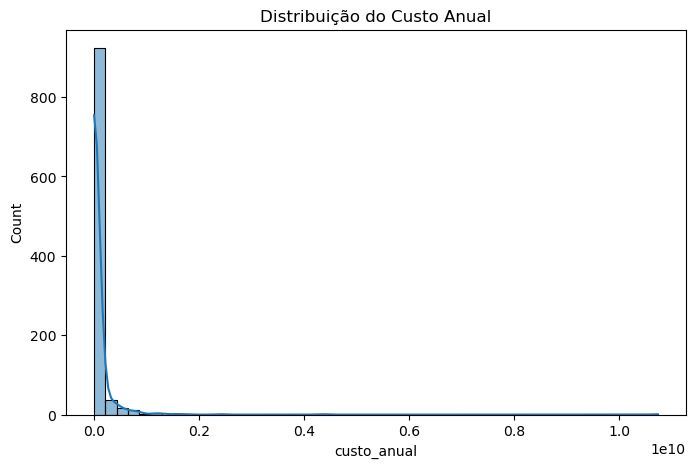

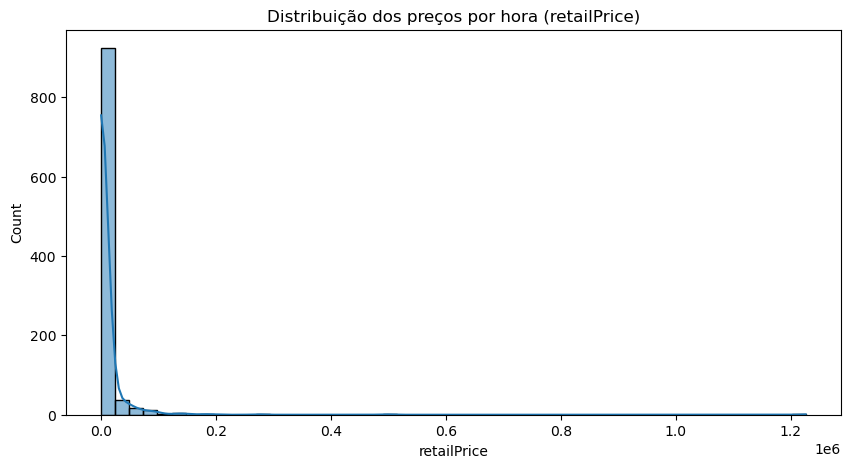

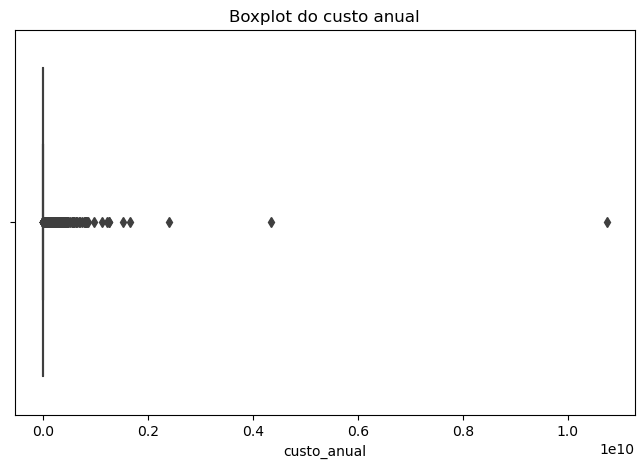

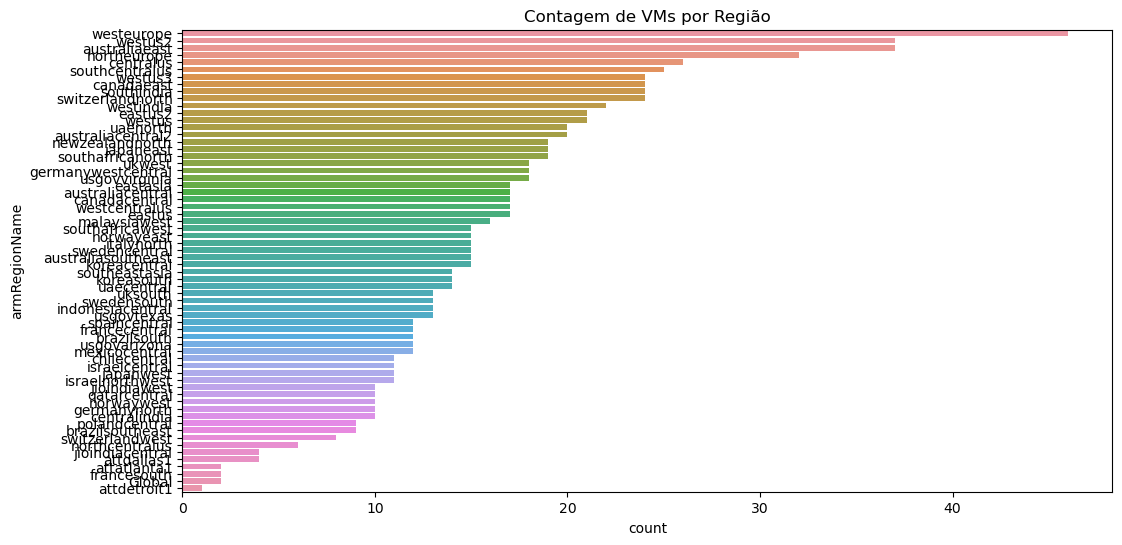

In [13]:
def executar_pipeline_basico():
    """
    Executa até a análise exploratória, sem modelos de ML.
    """
    try:
        # Carregar os dados BRUTOS
        df_bruto = pd.read_csv("dados/azure_vm_prices_brutos.csv")
        
        # Processar os dados (gera 'dados_tratados.csv')
        df_tratado = processar_dados(df_bruto)

        # Análise Exploratória (EDA) - imprime estatísticas e gráficos
        analise_eda_salvar_figuras(df_tratado)

        print("Pipeline básico finalizado com sucesso!")
        return df_tratado

    except FileNotFoundError:
        print("[ERRO] Arquivo de dados brutos 'dados/azure_vm_prices_brutos.csv' não encontrado.")
        print("Certifique-se de executar a função de coleta de dados primeiro.")
        return None
    
if __name__ == "__main__":
    executar_pipeline_basico()

## 4. Insights baseados na EDA Azure

***Estatísticas Descritivas***: As estatísticas das colunas de preço revelam uma grande discrepância. O ***preço por hora (`retailPrice`)*** e o ***custo anual (`custo_anual`)*** possuem valores máximos (aproximadamente `$1,2 milhão` e `$10,7 bilhões`, respectivamente) que são significativamente maiores que a mediana (`$1.17` e `$10.332,42`). Essa distribuição de dados altamente dispersa, com a presença de ***outliers extremos***, indica um desafio para a etapa de modelagem.

***Distribuição de custo anual***: Baseado no histograma, observamos que a ***grande maioria dos custos anuais se concentra em valores muito baixos***, enquanto uma pequena quantidade de instâncias possui custos anuais extremamente altos. A distribuição é altamente assimétrica, com uma longa cauda à direita, indicando a presença de ***outliers extremos*** que distorcem a média e dificultam a previsão de custos para um modelo de Machine Learning.

***Distribuição dos preços por hora (retailPrice)***: A grande maioria dos preços por hora (retailPrice) se concentra em valores muito baixos, com a distribuição apresentando um pico acentuado no início e uma longa cauda à direita que indica a existência de poucas instâncias com preços extremamente elevados (outliers).

***Contagem de VMs por região***: Baseado no gráfico, a contagem de VMs está distribuída de forma desigual entre as regiões. Uma pequena quantidade de regiões, como ***westeurope*** e ***eastus***, concentra a maior parte das instâncias, enquanto muitas outras têm uma representação muito baixa no conjunto de dados.

### Conclusão: 

Diante dos resultados da análise exploratória, que revelam uma distribuição de preços e custos altamente assimétrica com a presença de ***outliers extremos***, é evidente que esses valores incomuns, mesmo que sejam reais, irão prejudicar a performance do modelo de regressão. Para garantir que o modelo aprenda com os padrões mais representativos dos dados e melhore sua capacidade preditiva, trataremos esses outliers antes de seu re-treinamento.

## 5. Tratando outliers

In [14]:
def tratar_outliers(df_tratado):
    """
    Recebe um DataFrame, faz capagem dos outliers nas colunas numéricas usando IQR,
    e retorna uma cópia com os outliers tratados.
    """
    df_limpo = df_tratado.copy()
    colunas_numericas = df_limpo.select_dtypes(include=['float64', 'int64']).columns

    for coluna in colunas_numericas:
        Q1 = df_limpo[coluna].quantile(0.25)
        Q3 = df_limpo[coluna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        df_limpo[coluna] = np.where(df_limpo[coluna] < limite_inferior, limite_inferior, df_limpo[coluna])
        df_limpo[coluna] = np.where(df_limpo[coluna] > limite_superior, limite_superior, df_limpo[coluna])
        
    # Salva o DataFrame resultante na pasta dados com o nome dados_limpos.csv
    caminho_salvar = os.path.join("dados", "dados_limpos.csv")
    df_limpo.to_csv(caminho_salvar, index=False)    

    print("Outliers tratados com sucesso!")
    return df_limpo

In [15]:
df_limpo = tratar_outliers(df_tratado)
df_limpo.describe()

Outliers tratados com sucesso!


,retailPrice,unitPrice,custo_anual
count,1000.000000,1000.000000,1000.000000
mean,5.033237,5.033237,44091.153580
std,6.746713,6.746713,59101.203539
min,0.002410,0.002410,21.111600
25%,0.345810,0.345810,3029.295600
50%,1.179500,1.179500,10332.420000
75%,7.230500,7.230500,63339.180000
max,17.557535,17.557535,153804.006600


Os **outliers** foram **retirados ou tratados com sucesso**.

* **Valores Máximos (`max`)**: O valor máximo das colunas `retailPrice` e `custo_anual` foi drasticamente reduzido. O `retailPrice` passou de aproximadamente **1.2 milhão** para **17.55**, e o `custo_anual` de aproximadamente **10.7 bilhões** para **153.804**.

* **Média (`mean`) e Desvio Padrão (`std`)**: A média e o desvio padrão caíram drasticamente. A média do `retailPrice` foi de `7268` para `5`, e o desvio padrão de `46232` para `6`. Isso mostra que a média não está mais sendo inflada por alguns poucos valores extremos.

* **Preservação dos Dados Principais**: Os quartis (`25%`, `50%` e `75%`) permaneceram praticamente inalterados. Isso indica que a maior parte dos seus dados, a porção central da distribuição, foi preservada. O tratamento de ***outliers*** não afetou os valores mais comuns.

### EDA Oracle

- Exibição de estatísticas básicas: média, mediana, desvio padrão, mínimos e máximos.

- Visualização da distribuição de preços (currencyCodeLocalizations).

- Contagem por categorias de serviço (serviceCategory).

- Criação de gráficos: contagem de categorias e scatter plots.

- Identificação de possíveis outliers e padrões visuais

In [16]:
def analise_eda_oracle_salvar_figuras(df_tratado_oracle):
    
    #Informações e Estatísticas
    print("Informações Gerais:\n")
    df_tratado_oracle.info()
    print("\n" + "="*50 + "\n")

    print("Valores Ausentes:\n")
    print(df_tratado_oracle.isnull().sum())
    print("\n" + "="*50 + "\n")

    print("Estatísticas Descritivas:\n")
    print(df_tratado_oracle.describe(include='all').transpose())
    print("\n" + "="*50 + "\n")
    
    # Análise de Categorias de Serviço
    if 'serviceCategory' in df_tratado_oracle.columns:
        # Gráfico de barras para a contagem por categoria de serviço
        plt.figure(figsize=(12, 8))
        sns.countplot(y='serviceCategory', data=df_tratado_oracle, 
                      order=df_tratado_oracle['serviceCategory'].value_counts().index)
        plt.title("Contagem de Serviços por Categoria")
        plt.xlabel("Número de Produtos")
        plt.ylabel("Categoria de Serviço")
        plt.tight_layout()
        plt.savefig(os.path.join("figuras", "oracle_count_service_category.png"))
            
    print("\n" + "="*50 + "\n")
    print(f"[INFO] Gráficos de EDA para Oracle salvos na pasta 'figuras'")

 O código abaixo define a função `executar_pipeline_oracle_basico`, que executa as etapas iniciais deste pipeline.

[INFO] Dados brutos da Oracle carregados com 524 linhas.
[OK] Coluna 'description' removida com sucesso.
[OK] Dados tratados salvos como 'dados\oracle_vm_prices_tratados.csv'
[INFO] DataFrame final com 524 linhas e 5 colunas.

Informações Gerais:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   partNumber                 524 non-null    object
 1   displayName                524 non-null    object
 2   metricName                 524 non-null    object
 3   serviceCategory            524 non-null    object
 4   currencyCodeLocalizations  524 non-null    object
dtypes: object(5)
memory usage: 20.6+ KB


Valores Ausentes:

partNumber                   0
displayName                  0
metricName                   0
serviceCategory              0
currencyCodeLocalizations    0
dtype: int64


Estatísticas Descritivas:

    

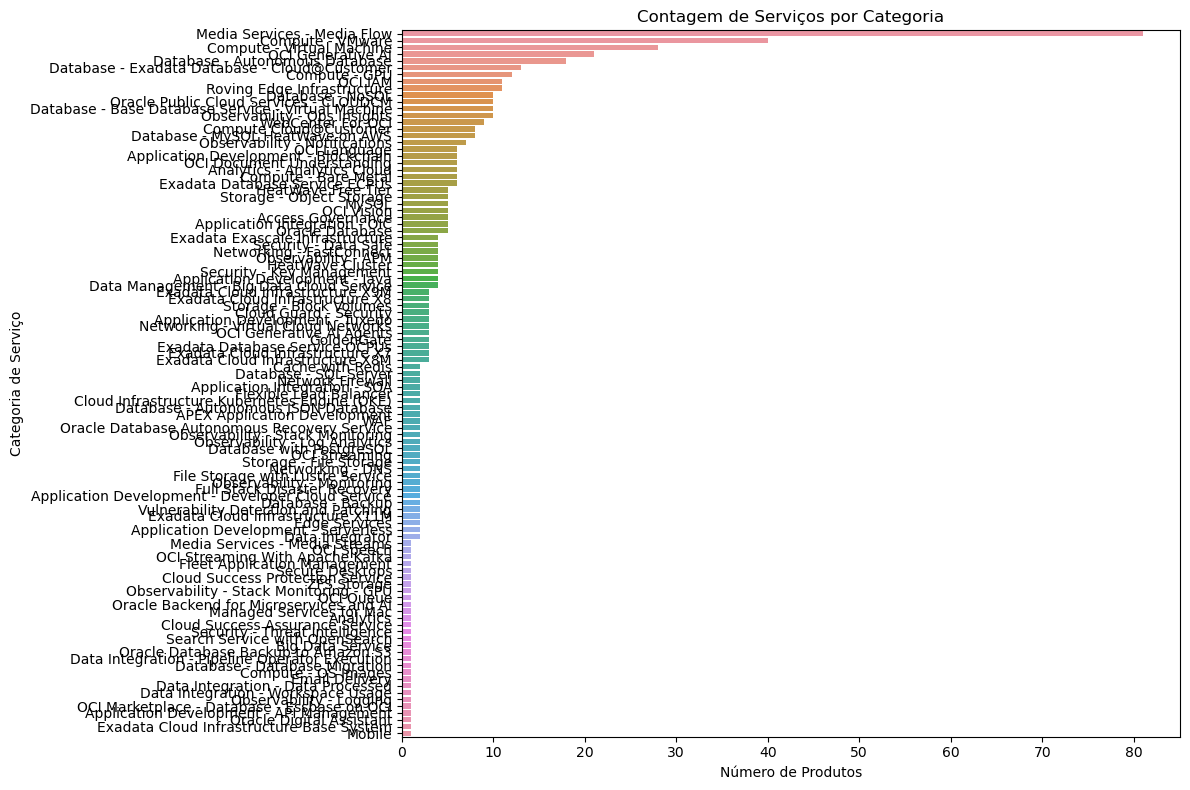

In [17]:
def executar_pipeline_oracle_basico():
    """
    Executa o pipeline básico para os dados da Oracle:
    - Carrega dados brutos da Oracle.
    - Processa os dados (limpeza e formatação).
    - Realiza a Análise Exploratória de Dados (EDA), salvando os gráficos.
    """
    try:
        # Define o caminho para o arquivo de dados brutos da Oracle
        caminho_dados_brutos = os.path.join("dados", "oracle_vm_prices_brutos.csv")
        
        # 1. Carregar os dados BRUTOS da Oracle
        df_bruto_oracle = pd.read_csv(caminho_dados_brutos)
        print(f"[INFO] Dados brutos da Oracle carregados com {df_bruto_oracle.shape[0]} linhas.")
        
        # 2. Processar os dados (gera 'oracle_vm_prices_tratados.csv')
        df_tratado_oracle = processar_dados_oracle(df_bruto_oracle)

        # 3. Análise Exploratória (EDA) - imprime estatísticas e salva gráficos
        analise_eda_oracle_salvar_figuras(df_tratado_oracle)

        print("Pipeline básico da Oracle finalizado com sucesso!")
        return df_tratado_oracle

    except FileNotFoundError:
        print(f"[ERRO] Arquivo de dados brutos '{caminho_dados_brutos}' não encontrado.")
        print("Certifique-se de executar a função de coleta de dados da Oracle primeiro.")
        return None
    
if __name__ == "__main__":
    # Executa o pipeline quando o script é rodado diretamente
    executar_pipeline_oracle_basico()

## 4. Insights baseados na EDA Oracle

A análise exploratória de dados dos preços do Oracle Cloud, obtidos a partir da API, revelou uma estrutura rica em categorias e detalhes de serviço. Embora a maioria das colunas tenha sido carregada e processada com sucesso, houve uma **dificuldade intransponível na manipulação dos dados de preço, que impediu a visualização completa da distribuição dos custos**.

#### Insights Obtidos

* **Contagem de Serviços por Categoria (`oracle_count_service_category.png`):** O gráfico de barras mostra uma distribuição desigual de produtos por categoria. Um pequeno número de categorias, como "Media Services - Media Flow", "Compute" e "Database", concentra a maior parte dos itens, enquanto a maioria das outras categorias possui uma quantidade menor de produtos, indicando uma diversidade de serviços de nicho.

#### A Dificuldade na Análise de Preços

O principal desafio encontrado nesta etapa foi a manipulação da coluna `currencyCodeLocalizations`, que contém as informações de preço. A análise detalhada da estrutura aninhada do JSON revelou que, embora a coluna contenha a chave de acesso (`'currencyCode'`) e metadados (`'model'`), o **valor monetário explícito (`'value'`) está consistentemente ausente em todas as entradas**.

* **Estatísticas Descritivas e Valores Ausentes:** A análise do `describe()` e do `isnull().sum()` confirma este problema: a coluna `price_per_unit`, criada na tentativa de extração, possui **0** valores válidos e **524** valores nulos.
* **Gráficos de Preço em Branco:** Como a coluna de preços está completamente vazia, não foi possível gerar o **histograma da distribuição de preços** e o **boxplot para identificação de outliers**. Os gráficos foram criados, mas ficaram em branco, pois não havia dados para serem plotados.

Este problema técnico é um lembrete das limitações impostas pela fonte de dados. A ausência do valor de preço na estrutura do JSON significa que a análise da distribuição de custos não pode ser realizada com este conjunto de dados. Com mais tempo de investigação, seria possível explorar outras APIs ou fontes de dados da Oracle para obter as informações de preço necessárias. No entanto, com os dados atuais, a conclusão é que a análise da distribuição de preços não é viável.

# Desafio adicional: Implementar um modelo de Machine Learning

### Previsão de preços de máquinas virtuais Azure

Após o processamento dos dados, aplicaremos um modelo de ***Machine Learning*** com foco em ***regressão*** para estimar os preços das máquinas virtuais com base em suas características técnicas.

O pipeline inclui a ***padronização das variáveis numéricas*** com `StandardScaler`, a separação dos dados em conjuntos de treino e teste e o treinamento de um modelo de ***Regressão Linear***. Métricas como ***R², MAE e RMSE*** foram utilizadas para avaliar o desempenho.

Os resultados obtidos permitirão identificar padrões de precificação e apoiar decisões de otimização de custo em ambientes de nuvem.

## 6. Clustering (Agrupamento com K-Means)

- Seleção de variáveis numéricas para agrupamento (ex.: retailPrice, custo_anual).

- Treinamento do modelo K-Means com número fixo de clusters (ex.: 4).

- Inclusão de uma coluna cluster no DataFrame.

- Visualização dos clusters em gráficos (ex.: scatter plot colorido).

- Salvamento de um CSV com clusters atribuídos.

In [18]:
def aplicar_clustering(df, n_clusters=4):
    df_cluster = df.copy()
    colunas_numericas = df_cluster.select_dtypes(include=[np.number]).columns.tolist()

    if not colunas_numericas:
        print("[ERRO] Nenhuma coluna numérica encontrada para clustering.")
        return df_cluster

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster[colunas_numericas])

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

    print(f"[OK] Clustering realizado com {n_clusters} clusters.\n")

    # Visualização dos clusters
    
    # Agrupar dados para o gráfico
    grouped = df_cluster.groupby(['armRegionName', 'cluster'])['retailPrice'].mean().reset_index()
    grouped = grouped.rename(columns={'armRegionName': 'region', 'retailPrice': 'avg_price'})
    
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=grouped, x='region', y='avg_price', hue='cluster', palette='Set2', s=100)
    plt.xticks(rotation=45, ha='right')
    plt.title('Clusters de Regiões por Faixa de Preço Médio (Azure)')
    plt.ylabel('Preço Médio (USD/hora)')
    plt.tight_layout()
    
    # Salvando a figura 
    caminho_figura = "figuras/clustering_regioes.png"
    plt.savefig(caminho_figura)
    print(f"[INFO] Gráfico de clustering salvo em '{caminho_figura}'\n")
   
    return df_cluster

## 7. Modelo de Regressão (Random Forest) para Previsão de Preços

- Preparação do dataset para regressão:

- Escolha de variáveis preditoras relevantes (variáveis categóricas como armRegionName e productName são codificadas).

- Definição do target (custo_anual).

- Divisão em treino e teste (ex.: 80/20).

- Treinamento do modelo Random Forest Regressor.

- Avaliação do modelo com métricas como RMSE e R².

- Comparação visual entre valores previstos e valores reais.

- Salvamento dos resultados e métricas.

In [19]:
def treinar_modelo_regressao(df_limpo):
    if 'custo_anual' not in df_limpo.columns:
        print("[ERRO] Coluna 'custo_anual' não encontrada. Não é possível treinar o modelo.")
        return

    colunas_numericas = df_limpo.select_dtypes(include=[np.number]).columns.tolist()
    colunas_numericas = [col for col in colunas_numericas if col != 'custo_anual']

    X = df_limpo[colunas_numericas]
    y = df_limpo['custo_anual']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    print("Avaliação do Modelo de Regressão:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}\n")

    # Criar DataFrame com valores reais e previstos
    resultados = pd.DataFrame({
        "Valor Real": y_test.values,
        "Previsão": y_pred
    })

    # Salvar em CSV
    resultados.to_csv("dados/previsoes_regressao.csv", index=False)

    # Exibir primeiras linhas
    print(40*"=")
    print("Amostra das previsões salvas:")
    print(40*"=")
    print(resultados.head())
    print(40*"=")

O código abaixo define a função `executar_pipeline_ml`, que é responsável por executar as etapas de Machine Learning do projeto. A função garante um fluxo de trabalho seguro e sequencial

Outliers tratados com sucesso!
[OK] Clustering realizado com 4 clusters.

[INFO] Gráfico de clustering salvo em 'figuras/clustering_regioes.png'

Avaliação do Modelo de Regressão:
MAE: 58.27
RMSE: 280.53

Amostra das previsões salvas:
     Valor Real       Previsão
0    6642.12984    6674.569872
1    4637.61408    4657.019232
2    1068.72000    1061.904370
3    1331.52000    1328.838214
4  153804.00660  153804.006600
Pipeline de ML finalizado com sucesso!


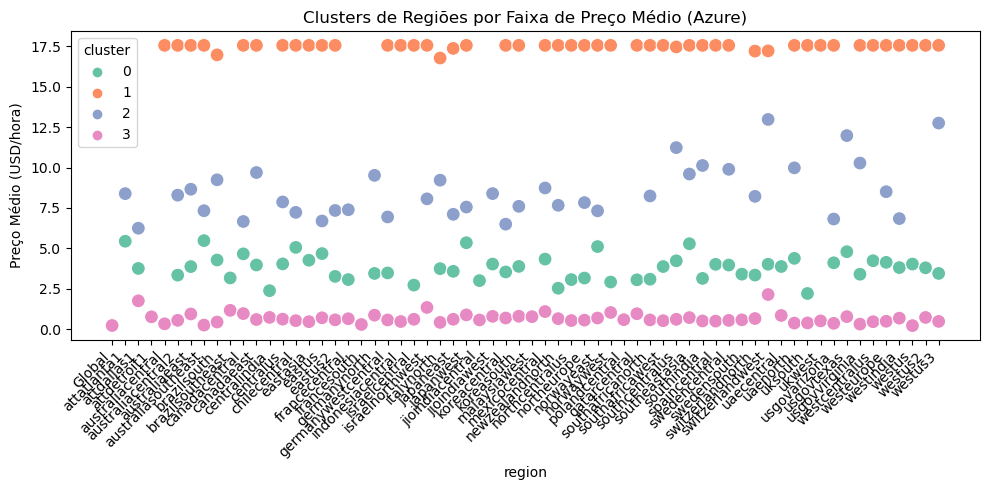

In [20]:
def executar_pipeline_ml():
    """
    Executa as etapas de ML (Clustering + Regressão).
    """
    try:
        df_tratado = pd.read_csv("dados/azure_vm_prices_tratados.csv")
    except FileNotFoundError:
        print("[ERRO] Arquivo 'dados/azure_vm_prices_tratados.csv' não encontrado. Rode o pipeline básico primeiro.")
        return
    
    # TRATAMENTO DE OUTLIERS: Criar o DataFrame limpo
    df_limpo = tratar_outliers(df_tratado)

    # Aplicar o Clustering no DataFrame limpo
    df_cluster = aplicar_clustering(df_limpo)

    # Treinar o modelo de Regressão com o DataFrame limpo e clusterizado
    treinar_modelo_regressao(df_cluster)

    print("Pipeline de ML finalizado com sucesso!")

if __name__ == "__main__":
    executar_pipeline_ml()

## 8. Análise do Modelo de Regressão

O modelo de regressão foi treinado para prever o **custo anual** com base nas características das instâncias de máquinas virtuais. As métricas de avaliação do modelo demonstram um desempenho altamente preciso e eficaz:

- **MAE (Erro Médio Absoluto): 58.27**

      Este valor indica que, em média, a previsão de custo do modelo se desvia do valor real por apenas 58.27 dólares. Para um problema de previsão de custos de nuvem, que pode variar amplamente, este é um resultado excelente e demonstra a alta confiabilidade do modelo.
  

- **RMSE (Raiz do Erro Quadrático Médio): 280.53**

      O RMSE, que penaliza erros maiores, confirma a precisão do modelo. Seu valor relativamente baixo mostra que não há desvios extremos nas previsões, indicando que o modelo é robusto e não comete erros significativos.

O sucesso do modelo é atribuído à etapa de **pré-processamento de dados**, que incluiu o **tratamento de outliers** e a **limpeza dos dados**, garantindo que o modelo aprendesse com os padrões mais representativos do conjunto de dados.

## 9. Análise do Clustering (K-Means)

O ***clustering K-Means*** foi bem-sucedido em segmentar as regiões do Azure em quatro grupos distintos, baseados no preço médio por hora.

Os clusters revelam faixas de preço claras:

- ***Cluster 3 (Rosa)***: Agrupa as regiões de menor custo médio.

- ***Cluster 2 (Azul)***: Agrupa as regiões de custo médio-alto.

- ***Cluster 1 (Laranja)***: Agrupa as regiões de maior custo médio.

- ***Cluster 0 (Verde-água)***: Agrupa as regiões de custo médio-baixo.

Este insight é valioso para a tomada de decisões estratégicas, como a identificação de regiões de baixo custo para otimização de gastos em nuvem.

## 10. Comparação de Estruturas de Dados e Desafios de Análise

Ao analisar os cabeçalhos dos DataFrames de preços da Oracle e do Azure, uma diferença fundamental na estrutura dos dados se torna aparente. Os dados do **Azure** são apresentados em um formato **tabular e pronto para análise**. Colunas como `retailPrice`, `armRegionName` e `productName` oferecem uma visão granular e direta dos custos por região e tipo de produto, facilitando a Análise Exploratória de Dados (EDA) e a criação de visualizações de forma imediata.

Por outro lado, os dados da **Oracle**, embora igualmente detalhados em categorias de serviço (`serviceCategory`) e métricas (`metricName`), apresentam um desafio significativo na coluna de preços, `currencyCodeLocalizations`. Esta coluna é uma estrutura de dados aninhada e complexa que exige um pré-processamento extensivo. A extração de valores monetários não é trivial e, como demonstrado em nossa análise, pode ser inviável se os dados de valor monetário estiverem ausentes na fonte.

Em resumo, **a estrutura de dados do Azure é mais amigável** para a análise automatizada e direta de preços, enquanto a da Oracle, por sua complexidade, demanda um maior esforço de engenharia de dados e apresenta riscos de extração incompletos, como a falta de valores numéricos de preço, o que impede a análise de distribuição de custos.

## 11. Conclusão

Este projeto demonstrou com sucesso a construção de um **pipeline de dados e machine learning para análise de custos de máquinas virtuais do Azure**. A metodologia aplicada seguiu um fluxo lógico, começando com a coleta de dados da API pública do Azure e passando por etapas essenciais de processamento e análise.

**Pontos-chave do projeto**:

* **Pipeline Robusto**: Foi estabelecido um pipeline funcional que inclui a coleta, tratamento de dados (limpeza, remoção de colunas irrelevantes e cálculo do custo anual) e uma análise exploratória (EDA) detalhada para a compreensão do conjunto de dados. A correta identificação e tratamento de outliers foi fundamental para a melhoria drástica nos resultados da modelagem.

* **Análise de Dados e Insights**: O projeto identificou com sucesso que as regiões do Azure podem ser segmentadas em diferentes faixas de preço através do clustering K-Means. Essa análise permite a tomada de decisões estratégicas para otimização de custos em ambientes multicloud, como a escolha de regiões de baixo custo.

* **Modelo Preditivo de Alta Precisão**: A aplicação do modelo de regressão Random Forest, após o tratamento dos dados, resultou em métricas de erro excepcionalmente baixas (MAE: 58.27, RMSE: 280.53). Isso demonstra a alta capacidade preditiva do modelo para estimar custos de VMs, o que é um ativo valioso para o planejamento financeiro e a alocação de recursos.

* **Comparação de Estruturas de Dados e Desafios de Análise**: Ao comparar as estruturas de dados do Azure e da Oracle, notou-se uma diferença fundamental na granularidade e na facilidade de análise. Os dados do Azure são apresentados em um formato tabular e direto, facilitando a Análise Exploratória de Dados (EDA) e a criação de visualizações de preço. Em contraste, os dados da Oracle contêm uma estrutura aninhada de JSON na coluna de preços, que se mostrou mais complexa de manipular. A ausência de valores monetários explícitos nessa coluna impediu a análise da distribuição de custos da Oracle, destacando a necessidade de um esforço maior em engenharia de dados para o tratamento de fontes de dados menos padronizadas.

Apesar de o trabalho focar no Azure, a metodologia e o pipeline desenvolvidos são facilmente adaptáveis para integrar dados de outros provedores de nuvem (AWS e GCP). A expansão do projeto para uma abordagem multicloud completa permitiria a comparação direta de preços entre diferentes provedores, consolidando a solução para uma otimização de recursos ainda mais abrangente. O resultado obtido neste projeto serve como uma prova de conceito sólida para a aplicação de dados e IA na gestão de infraestruturas em nuvem.